# Lagrange Interpolation
Saleh Rezaeiravesh, salehr@kth.se <br/>
SimEx/FLOW, Engineering Mechanics, KTH Royal Institute of Technology, Stockholm, Sweden


In [1]:
import os
import sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
sys.path.append(os.getenv("UQit"))
from lagInt import lagInt, lagInt_Quads2Line
import analyticTestFuncs
import sampling
import pce
import reshaper

### Example 1: Lagrange interpolation over a 1D parameter space. 


Consider a model function that only depends on one uncertain parameter $q_1\in \mathbb{Q}_1$. 
The aim is to construct a 1D Lagrange interpolation based on a limited number of samples drawn from $\mathbb{Q}_1$. 
`UQit` provides different methods for drawing samples via `sampling.trainSample` for an uncertain parameter, and of course it can handle any arbitrary set of samples which are provided by the user. 

The model function is defied as, 
$$
\begin{equation}
r=10+0.7\sin(5q_1)+3 \cos(q_1)
\end{equation}
$$

Given samples for $q_1$, the values of this function can be generated via `analyticTestFuncs.fEx1D(typ='type1')`. 
To construct the Lagrange interpolation using the data, we take the following steps:

**Step 1:** Set the settings; we set the number of nodes (parameter samples), the admissible space of the parameters $\mathbb{Q}_1$, how the samples are drawn (if using `trainSample`), and the number of test points in the parameter space at which the constructed Lagrange interpolation is evaluated. 

In [2]:
nNodes=9          #number of training samples (nodes)
qBound=[-1,3]     #range over which the samples are taken
nTest=100         #number of test points
sampType='GLL'    #Type of samples, see trainSample class in sampling.py

**Step 2:** Draw samples for the parameter and run the simulator at each sample (generate training data). 

In [3]:
samps_=sampling.trainSample(sampleType=sampType,qInfo=qBound,nSamp=nNodes)
qNodes=samps_.q
fNodes=analyticTestFuncs.fEx1D(qNodes,'type1',qBound).val

**Step 3:** Generate the test samples.

In [4]:
qTestFull=np.linspace(qBound[0],qBound[1],nTest)
qTest=np.linspace(min(qNodes),max(qNodes),nTest)

**Step 4:** Construct the Lagrange interpolation and evaluate it at the test points.

In [5]:
fInterpTest=lagInt(fNodes=fNodes,qNodes=[qNodes],qTest=[qTest]).val

**Step 5:** Plot and validation.

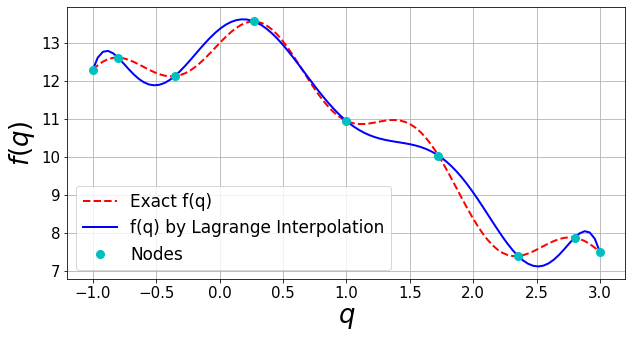

In [6]:
fTestFull=analyticTestFuncs.fEx1D(qTestFull,'type1',qBound).val
plt.figure(figsize=(10,5))
plt.plot(qTestFull,fTestFull,'--r',lw=2,label='Exact f(q)')
plt.plot(qTest,fInterpTest,'-b',lw=2,label='f(q) by Lagrange Interpolation')
plt.plot(qNodes,fNodes,'oc',markersize='8',label='Nodes')
plt.legend(loc='best',fontsize=17)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid()
plt.xlabel(r'$q$',fontsize=26)
plt.ylabel(r'$f(q)$',fontsize=26)
plt.show()

**Extra:** There are different factors that control the accuracy of a Lagrange interpolation. These include the number of training samples (nodes) and how they are generated. Try to rerun the above example adopting different values for `nNodes` and `sampType`.
Here is the list of available `sampType` in `sampling.trainSample`:

`['GQ','GLL','unifSpaced','unifRand','normRand','Clenshaw','Clenshaw-Curtis']`

### Example 2: Lagrange interpolation over a 2D parameter space. 
Consider a model function which depends on parameters $q_1\in \mathbb{Q}_1$ and $q_2\in\mathbb{Q}_2$. 
Let $\mathbb{Q}^*_1\bigotimes\mathbb{Q}^*_2$ be a subspace of $\mathbb{Q}_1\bigotimes\mathbb{Q}_2$. 
Through a few number of samples taken from $\mathbb{Q}^*_1\bigotimes\mathbb{Q}^*_2$ and constructing a Lagrange interpolation, we want to reconstruct the response surface.

As the model function (simulator), we consider
$$
\begin{eqnarray}
r=f(\mathbf{q}) &=& 3 \exp\left(-(q_2+2)^2-q_1^2\right)\left(q_1-1\right)^2 \\
                &-& \exp\left(-(q_1+2)^2-q_1^2\right)/3 \\
                &+& \exp\left(-(q_1^2+q_2^2)\right)\left(10q_1^3-2q_1+10q_2^5\right)\,,
\end{eqnarray}
$$

which is implemented in `UQit` in `analyticTestFuncs.fEx2D()` with keyword `type1`.

**Step 1:** Settings

In [7]:
nNodes=[5,4]          #number of  training samples nodes in space of parameters q1, q2
sampType=['GLL',      #Method of drawing samples for q1, q2
          'unifRand']
qBound=[[-0.75,1.5],  # admissible range of parameters, Q*_1, Q*_2
        [-0.5 ,2.5]]

# Settings of the exact response surface
domRange=[[-2,2], #Q_1, Q_2, domain range for q1, q2
          [-3,3]]
nTest=[100,101] #number of test samples 

**Step 2:** Create the training samples over each parameter space

In [8]:
p=len(nNodes)
qNodes=[]
for i in range(p):
    qNodes_=sampling.trainSample(sampleType=sampType[i],qInfo=qBound[i],nSamp=nNodes[i])
    qNodes.append(qNodes_.q)

**Step 3:** Evaluate the simulator at each joint sample

In [9]:
fNodes=analyticTestFuncs.fEx2D(qNodes[0],qNodes[1],'type1','tensorProd').val

**Step 4:** Generate the test samples

In [10]:
qTestList=[]
for i in range(p):
    qTest_=sampling.testSample(sampleType='unifSpaced',qBound=qBound[i],nSamp=nTest[i])
    qTestList.append(qTest_.q)

**Step 5:** Construct the Lagrange interpolation and evaluate it at the test samples

In [11]:
fTest=lagInt(fNodes=fNodes,qNodes=qNodes,qTest=qTestList,liDict={'testRule':'tensorProd'}).val

**Step 5:** Plot the original and interpolated response surfaces.

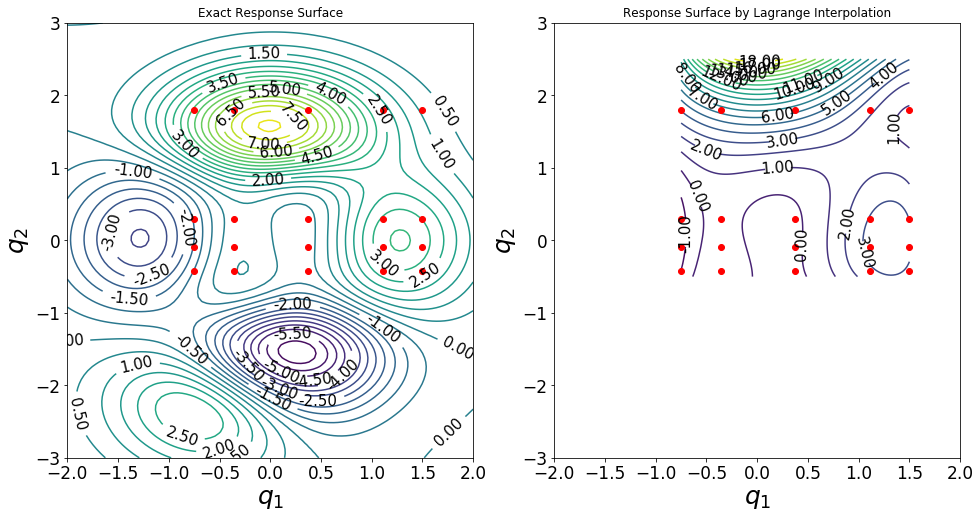

In [12]:
# Evaluate the exact model response over domRange
qTestFull=[]
for i in range(p):
    qTestFull_=np.linspace(domRange[i][0],domRange[i][1],nTest[i])
    qTestFull.append(qTestFull_)
fTestFull=analyticTestFuncs.fEx2D(qTestFull[0],qTestFull[1],'type1','tensorProd').val
fTestFullGrid=fTestFull.reshape((nTest[0],nTest[1]),order='F').T
fTestGrid=fTest.reshape((nTest[0],nTest[1]),order='F').T
# Plots
plt.figure(figsize=(16,8));
plt.subplot(1,2,1)
ax=plt.gca()
CS1 = plt.contour(qTestFull[0],qTestFull[1],fTestFullGrid,35)
plt.clabel(CS1, inline=True, fontsize=15,colors='k',fmt='%0.2f',rightside_up=True,manual=False)
qNodesGrid=reshaper.vecs2grid(qNodes)
plt.plot(qNodesGrid[:,0],qNodesGrid[:,1],'o',color='r',markersize=6)
plt.xlabel(r'$q_1$',fontsize=25);plt.ylabel(r'$q_2$',fontsize=25);
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.title('Exact Response Surface')
plt.subplot(1,2,2)
ax=plt.gca()
CS2 = plt.contour(qTestList[0],qTestList[1],fTestGrid,20)
plt.clabel(CS2, inline=True, fontsize=15,colors='k',fmt='%0.2f',rightside_up=True,manual=False)
plt.plot(qNodesGrid[:,0],qNodesGrid[:,1],'o',color='r',markersize=6)
plt.xlabel(r'$q_1$',fontsize=25);plt.ylabel(r'$q_2$',fontsize=25);
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.title('Response Surface by Lagrange Interpolation')
plt.xlim(domRange[0])
plt.ylim(domRange[1])
plt.show()

**Extra:** Try different types and numbers of training samples for parameters $q_1$ and $q_2$.

### Example 3:  Lagrange interpolation over a 3D parameter space.

Consider the [Ishigami](https://inis.iaea.org/search/search.aspx?orig_q=RN:21024954) function,
$$
\begin{equation}
f(\mathbf{q}) = \sin(q_1)+a\sin^2(q_2)+b\,q_3^4\sin(q_1) \,.
\label{eq:ishigami}\tag{4}
\end{equation}
$$

where $q_i\in \mathbb{Q}_i\,,i=1,2,3$.
We want to find the error between the actual function values and what prediction by the Lagrange interpolation constructed based on a limited number of samples. 

We follow the same steps as in the previous examples:

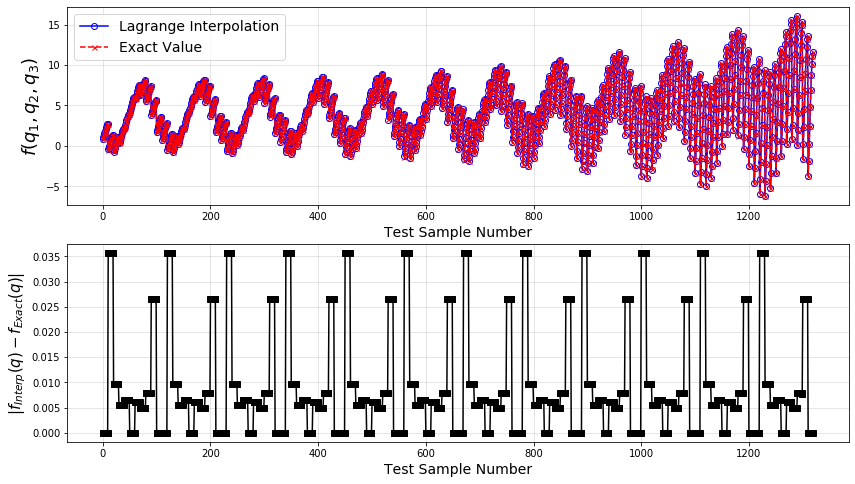

In [13]:
#----- SETTINGS -------------------
nNodes=[8,7,6]         #number of training samples for q1, q2, q3
sampType=['GLL',       #Type of samples for q1, q2, q3
          'unifSpaced',
          'Clenshaw']
qBound=[[-0.75,1.5],   #range of parameters q1, q2, q3
        [-0.5 ,2.5],
        [1,3]]
nTest=[10,11,12]       #number of test samples for q1, q2, q3
fOpts={'a':7,'b':0.1}  #parameters in Ishigami function
#----------------------------------
p=len(nNodes)
# Generate the training samples
qNodes=[]
for i in range(p):
    qNodes_=sampling.trainSample(sampleType=sampType[i],qInfo=qBound[i],nSamp=nNodes[i])
    qNodes.append(qNodes_.q)
# Run the simulator at the training samples   
fNodes=analyticTestFuncs.fEx3D(qNodes[0],qNodes[1],qNodes[2],'Ishigami','tensorProd',fOpts).val
# Create the test samples and run the simultor at them
qTest=[]
for i in range(p):
    qTest_=sampling.testSample(sampleType='unifSpaced',qBound=qBound[i],nSamp=nTest[i])
    qTest.append(qTest_.q)
fTestEx=analyticTestFuncs.fEx3D(qTest[0],qTest[1],qTest[2],'Ishigami','tensorProd',fOpts).val
# Construct the Lagrange interpolation an evaluate it at the test samples
fInterp=lagInt(fNodes=fNodes,qNodes=qNodes,qTest=qTest,liDict={'testRule':'tensorProd'}).val
# Plot
plt.figure(figsize=(14,8))
plt.subplot(2,1,1)
fInterp_=fInterp.reshape(np.asarray(np.prod(np.asarray(nTest))),order='F')
plt.plot(fInterp_,'-ob',mfc='none',label='Lagrange Interpolation')
plt.plot(fTestEx,'--xr',ms=5,label='Exact Value')
plt.ylabel(r'$f(q_1,q_2,q_3)$',fontsize=18)
plt.xlabel(r'Test Sample Number',fontsize=14)
plt.legend(loc='best',fontsize=14)
plt.grid(alpha=0.4)
plt.subplot(2,1,2)
plt.plot(abs(fInterp_-fTestEx),'-sk')
plt.ylabel(r'$|f_{Interp}(q)-f_{Exact}(q)|$',fontsize=15)
plt.xlabel(r'Test Sample Number',fontsize=14)
plt.grid(alpha=0.4)
plt.show()

Clearly, the error between the exact values of the Ishigami function and the values obtained by the Lagrange interpolation constructed from a limited number of samples is very small. One can investigate how different number and type of the training samples would influence the accuracy of the resulting interpolation. 